# Multi-Class WCP-L2D: 7-Pathology Weighted Conformal Prediction

Extends the binary WCP-L2D experiment to a 7-class classification setting.
With K=7, prediction sets range from size 0 to 7, enabling graded deferral
behavior and eliminating the binary CP bottleneck.

**Methods compared:**
- Max Logit (uncalibrated threshold sweep)
- Continuous deferral (source-calibrated and DRE-weighted thresholds)
- Standard CP (APS)
- Weighted CP (WCP + APS)
- All of the above with temperature scaling

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.special import softmax
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from wcp_l2d.features import ExtractedFeatures
from wcp_l2d.pathologies import COMMON_PATHOLOGIES, NUM_PATHOLOGIES
from wcp_l2d.label_utils import multilabel_to_singlelabel, compute_pathology_prevalence
from wcp_l2d.dre import AdaptiveDRE
from wcp_l2d.conformal import ConformalPredictor, WeightedConformalPredictor
from wcp_l2d.temperature import calibrate_temperature, apply_temperature
from wcp_l2d.evaluation import (
    evaluate_max_logit,
    evaluate_standard_cp,
    evaluate_wcp,
    evaluate_continuous_deferral,
    _predictions_from_sets,
    plot_coverage_comparison,
)
from wcp_l2d.expert import DEFAULT_SENSITIVITY

SEED = 42
K = NUM_PATHOLOGIES  # 7
EXPERT_ACCURACY = 0.85
FEATURE_DIR = Path("../../data/features")

np.random.seed(SEED)
torch.manual_seed(SEED)
print(f"K={K} classes: {COMMON_PATHOLOGIES}")
print(f"Expert accuracy (flat): {EXPERT_ACCURACY}")

## 1. Load Features & Prepare Multi-Class Labels

In [2]:
# Load pre-extracted DenseNet121 features
chexpert = ExtractedFeatures.load(
    FEATURE_DIR / "chexpert_densenet121-res224-chex_features.npz"
)
nih = ExtractedFeatures.load(FEATURE_DIR / "nih_densenet121-res224-chex_features.npz")

print(f"CheXpert raw: {chexpert.features.shape}")
print(f"NIH raw:      {nih.features.shape}")

# Compute CheXpert prevalence for consistent tie-breaking
chex_prevalence = compute_pathology_prevalence(chexpert.labels, COMMON_PATHOLOGIES)
print("\nCheXpert prevalence per pathology:")
for p, v in chex_prevalence.items():
    print(f"  {p:<16}: {v:.4f}")

# Convert multi-label to single-label (keep samples with >= 1 positive)
chex_feats, chex_labels, chex_mask = multilabel_to_singlelabel(
    chexpert.features,
    chexpert.labels,
    COMMON_PATHOLOGIES,
    prevalence=chex_prevalence,
)
nih_feats, nih_labels, nih_mask = multilabel_to_singlelabel(
    nih.features,
    nih.labels,
    COMMON_PATHOLOGIES,
    prevalence=chex_prevalence,
)

print(f"\nAfter multilabel_to_singlelabel:")
print(
    f"  CheXpert: {len(chex_labels)} / {len(chexpert.labels)} ({len(chex_labels) / len(chexpert.labels) * 100:.1f}%)"
)
print(
    f"  NIH:      {len(nih_labels)} / {len(nih.labels)} ({len(nih_labels) / len(nih.labels) * 100:.1f}%)"
)

print("\nCheXpert class distribution:")
for i, count in enumerate(np.bincount(chex_labels, minlength=K)):
    print(
        f"  {COMMON_PATHOLOGIES[i]:<16}: {count:5d} ({count / len(chex_labels) * 100:.1f}%)"
    )
print("\nNIH class distribution:")
for i, count in enumerate(np.bincount(nih_labels, minlength=K)):
    print(
        f"  {COMMON_PATHOLOGIES[i]:<16}: {count:5d} ({count / len(nih_labels) * 100:.1f}%)"
    )

CheXpert raw: (64534, 1024)
NIH raw:      (30805, 1024)

CheXpert prevalence per pathology:
  Atelectasis     : 0.4699
  Cardiomegaly    : 0.3387
  Consolidation   : 0.1932
  Edema           : 0.4200
  Effusion        : 0.4676
  Pneumonia       : 0.1602
  Pneumothorax    : 0.1165

After multilabel_to_singlelabel:
  CheXpert: 36907 / 64534 (57.2%)
  NIH:      3826 / 30805 (12.4%)

CheXpert class distribution:
  Atelectasis     :  3324 (9.0%)
  Cardiomegaly    :  7112 (19.3%)
  Consolidation   :  4274 (11.6%)
  Edema           :  8055 (21.8%)
  Effusion        :  7175 (19.4%)
  Pneumonia       :  2656 (7.2%)
  Pneumothorax    :  4311 (11.7%)

NIH class distribution:
  Atelectasis     :  1250 (32.7%)
  Cardiomegaly    :   756 (19.8%)
  Consolidation   :   415 (10.8%)
  Edema           :    49 (1.3%)
  Effusion        :   930 (24.3%)
  Pneumonia       :   174 (4.5%)
  Pneumothorax    :   252 (6.6%)


## 2. Data Splits

In [3]:
# CheXpert: 60/20/20 train/cal/test (stratified by 7-class label)
chex_tr_f, chex_tmp_f, chex_tr_l, chex_tmp_l = train_test_split(
    chex_feats, chex_labels, test_size=0.4, random_state=SEED, stratify=chex_labels
)
chex_cal_f, chex_te_f, chex_cal_l, chex_te_l = train_test_split(
    chex_tmp_f, chex_tmp_l, test_size=0.5, random_state=SEED, stratify=chex_tmp_l
)

# NIH pool (unlabeled, for DRE) = random 50% of ALL NIH features
rng = np.random.RandomState(SEED)
nih_all_perm = rng.permutation(len(nih.features))
nih_pool_feats_all = nih.features[nih_all_perm[: len(nih.features) // 2]]

# NIH test: 50% of label-filtered NIH (stratified)
_, nih_te_f, _, nih_te_l = train_test_split(
    nih_feats, nih_labels, test_size=0.5, random_state=SEED, stratify=nih_labels
)

print(
    f"CheXpert train: {len(chex_tr_l)} (min_class={np.bincount(chex_tr_l, minlength=K).min()})"
)
print(
    f"CheXpert cal:   {len(chex_cal_l)} (min_class={np.bincount(chex_cal_l, minlength=K).min()})"
)
print(
    f"CheXpert test:  {len(chex_te_l)} (min_class={np.bincount(chex_te_l, minlength=K).min()})"
)
print(f"NIH pool (DRE): {len(nih_pool_feats_all)} (all features, unlabeled)")
print(
    f"NIH test:       {len(nih_te_l)} (min_class={np.bincount(nih_te_l, minlength=K).min()})"
)

print("\nNIH test class distribution:")
for i, count in enumerate(np.bincount(nih_te_l, minlength=K)):
    print(f"  {COMMON_PATHOLOGIES[i]:<16}: {count:5d}")

CheXpert train: 22144 (min_class=1594)
CheXpert cal:   7381 (min_class=531)
CheXpert test:  7382 (min_class=531)
NIH pool (DRE): 15402 (all features, unlabeled)
NIH test:       1913 (min_class=24)

NIH test class distribution:
  Atelectasis     :   625
  Cardiomegaly    :   378
  Consolidation   :   208
  Edema           :    24
  Effusion        :   465
  Pneumonia       :    87
  Pneumothorax    :   126


## 3. Train 7-Class Classifier

In [18]:
# Normalize features
scaler = StandardScaler()
X_tr = scaler.fit_transform(chex_tr_f)
X_cal = scaler.transform(chex_cal_f)
X_te_chex = scaler.transform(chex_te_f)
X_te_nih = scaler.transform(nih_te_f)

# Multi-class logistic regression (multinomial with lbfgs)
clf = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    C=1.0,
    random_state=SEED,
)
clf.fit(X_tr, chex_tr_l)

# Multi-class logits via decision_function: [N, 7]
tr_logits = clf.decision_function(X_tr)
cal_logits = clf.decision_function(X_cal)
te_chex_logits = clf.decision_function(X_te_chex)
te_nih_logits = clf.decision_function(X_te_nih)

print(f"Logits shape: {cal_logits.shape}")
print(f"Logits range: [{cal_logits.min():.3f}, {cal_logits.max():.3f}]")

print("\n7-class classifier performance:")
for name, X, y in [
    ("CheXpert train", X_tr, chex_tr_l),
    ("CheXpert cal", X_cal, chex_cal_l),
    ("CheXpert test", X_te_chex, chex_te_l),
    ("NIH test", X_te_nih, nih_te_l),
]:
    acc = clf.score(X, y)
    preds = clf.predict(X)
    logits = clf.decision_function(X)
    probs = softmax(logits, axis=1)
    # Per-class OvR AUC & Accuracy
    aucs = []
    cls_to_print = []
    for c in range(K):
        mask = y == c
        if mask.sum() > 0:
            c_acc = (preds[mask] == y[mask]).mean()
            cls_to_print.append(f"{COMMON_PATHOLOGIES[c][:3]}={c_acc:.2f}")

        if len(np.unique(mask)) < 2:
            continue
        aucs.append(roc_auc_score(mask, probs[:, c]))

    mean_auc = np.mean(aucs)
    print(f"  {name:<16} acc={acc:.4f}  mean_OvR_AUC={mean_auc:.4f}")
    print(f"    Per-class acc: {', '.join(cls_to_print)}")

Logits shape: (7381, 7)
Logits range: [-27.470, 14.461]

7-class classifier performance:
  CheXpert train   acc=0.4335  mean_OvR_AUC=0.7845
    Per-class acc: Ate=0.39, Car=0.61, Con=0.20, Ede=0.52, Eff=0.45, Pne=0.18, Pne=0.37
  CheXpert cal     acc=0.3238  mean_OvR_AUC=0.6779
    Per-class acc: Ate=0.28, Car=0.50, Con=0.10, Ede=0.41, Eff=0.32, Pne=0.08, Pne=0.29
  CheXpert test    acc=0.3322  mean_OvR_AUC=0.6803
    Per-class acc: Ate=0.26, Car=0.50, Con=0.12, Ede=0.42, Eff=0.36, Pne=0.11, Pne=0.25
  NIH test         acc=0.2933  mean_OvR_AUC=0.5952
    Per-class acc: Ate=0.32, Car=0.39, Con=0.03, Ede=0.25, Eff=0.40, Pne=0.13, Pne=0.03


## 4. Temperature Scaling

In [5]:
# Calibrate temperature on TRAINING set (avoid double-use of cal set)
T_opt = calibrate_temperature(tr_logits, chex_tr_l)
print(f"Optimal temperature: T = {T_opt:.4f}")

# Apply temperature scaling
cal_logits_ts = apply_temperature(cal_logits, T_opt)
te_chex_logits_ts = apply_temperature(te_chex_logits, T_opt)
te_nih_logits_ts = apply_temperature(te_nih_logits, T_opt)

# Verify calibration improvement
print("\nCalibration quality (NLL, mean max-prob):")
for name, logits, labels in [
    ("cal (T=1.0)", cal_logits, chex_cal_l),
    (f"cal (T={T_opt:.2f})", cal_logits_ts, chex_cal_l),
    ("NIH (T=1.0)", te_nih_logits, nih_te_l),
    (f"NIH (T={T_opt:.2f})", te_nih_logits_ts, nih_te_l),
]:
    probs = softmax(logits, axis=1)
    p_true = probs[np.arange(len(labels)), labels]
    nll = -np.log(np.clip(p_true, 1e-12, 1.0)).mean()
    max_p = probs.max(axis=1).mean()
    print(f"  {name:<20}: NLL={nll:.4f}, mean_max_prob={max_p:.4f}")

Optimal temperature: T = 0.9894

Calibration quality (NLL, mean max-prob):
  cal (T=1.0)         : NLL=1.7911, mean_max_prob=0.4314
  cal (T=0.99)        : NLL=1.7944, mean_max_prob=0.4343
  NIH (T=1.0)         : NLL=2.0980, mean_max_prob=0.4574
  NIH (T=0.99)        : NLL=2.1053, mean_max_prob=0.4604


## 5. Adaptive DRE

In [6]:
# DRE with PCA(4) — same as binary experiment
dre = AdaptiveDRE(n_components=4, weight_clip=20.0, random_state=SEED)
dre.fit(
    source_features=chex_cal_f,
    target_features=nih_pool_feats_all,
)

cal_weights = dre.compute_weights(chex_cal_f)
te_nih_weights = dre.compute_weights(nih_te_f)

diag = dre.diagnostics(chex_cal_f)
print("DRE Diagnostics:")
print(f"  Domain classifier AUC: {diag.domain_auc:.4f}")
print(f"  ESS: {diag.ess:.1f} / {len(cal_weights)} = {diag.ess_fraction:.3f}")
print(f"  Weights: mean={diag.weight_mean:.4f}, std={diag.weight_std:.4f}")
print(
    f"           min={diag.weight_min:.6f}, max={diag.weight_max:.4f}, median={diag.weight_median:.4f}"
)

DRE Diagnostics:
  Domain classifier AUC: 0.9701
  ESS: 474.0 / 7381 = 0.064
  Weights: mean=0.4514, std=1.7233
           min=0.000003, max=20.0000, median=0.0286


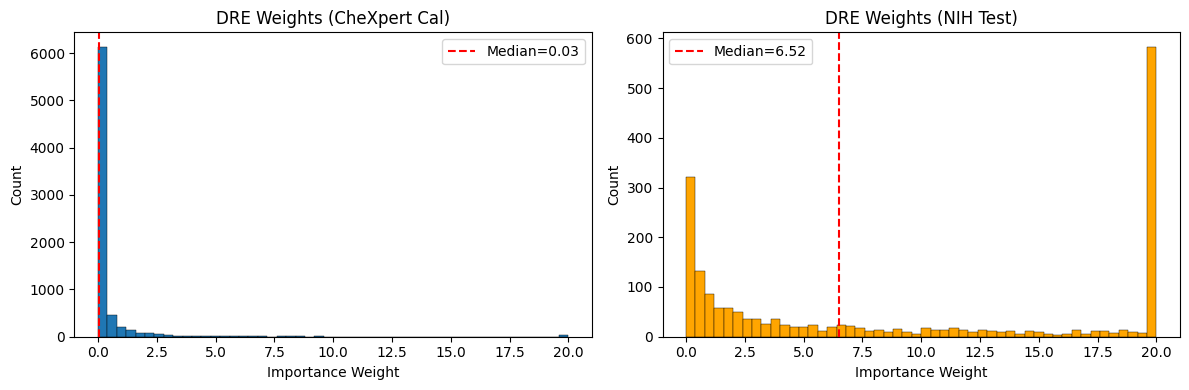

In [7]:
# Weight distribution plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(cal_weights, bins=50, edgecolor="black", linewidth=0.3)
axes[0].set_xlabel("Importance Weight")
axes[0].set_ylabel("Count")
axes[0].set_title("DRE Weights (CheXpert Cal)")
axes[0].axvline(
    x=np.median(cal_weights),
    color="red",
    linestyle="--",
    label=f"Median={np.median(cal_weights):.2f}",
)
axes[0].legend()

axes[1].hist(te_nih_weights, bins=50, edgecolor="black", linewidth=0.3, color="orange")
axes[1].set_xlabel("Importance Weight")
axes[1].set_ylabel("Count")
axes[1].set_title("DRE Weights (NIH Test)")
axes[1].axvline(
    x=np.median(te_nih_weights),
    color="red",
    linestyle="--",
    label=f"Median={np.median(te_nih_weights):.2f}",
)
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Baseline — Max Logit Deferral (Fixed Threshold Sweep)

In [8]:
thresholds = np.linspace(0.1, 0.99, 50)

ml_results = evaluate_max_logit(
    te_nih_logits_ts, nih_te_l, thresholds, expert_accuracy=EXPERT_ACCURACY
)

for target_defer in [0.2, 0.5]:
    r = min(ml_results, key=lambda r: abs(r.deferral_rate - target_defer))
    print(
        f"Max Logit at ~{target_defer:.0%} deferral: "
        f"sys_acc={r.system_accuracy:.4f}, defer={r.deferral_rate:.4f}"
    )

Max Logit at ~20% deferral: sys_acc=0.4281, defer=0.2081
Max Logit at ~50% deferral: sys_acc=0.5949, defer=0.4835


## 7. Continuous Deferral with Calibrated Thresholds

Uses u(x) = 1 - max(softmax) as the uncertainty score.
The threshold is set via a quantile of calibration scores:
- Source-calibrated: unweighted quantile
- DRE-weighted: importance-weighted quantile

In [9]:
alphas = np.linspace(0.01, 0.90, 50)

# Source-calibrated (no DRE weights)
cont_source_results = evaluate_continuous_deferral(
    cal_logits_ts,
    chex_cal_l,
    te_nih_logits_ts,
    nih_te_l,
    alphas,
    cal_weights=None,
    expert_accuracy=EXPERT_ACCURACY,
)

# DRE-weighted
cont_dre_results = evaluate_continuous_deferral(
    cal_logits_ts,
    chex_cal_l,
    te_nih_logits_ts,
    nih_te_l,
    alphas,
    cal_weights=cal_weights,
    expert_accuracy=EXPERT_ACCURACY,
)

# DRE-weighted without temperature scaling (ablation)
cont_dre_nots_results = evaluate_continuous_deferral(
    cal_logits,
    chex_cal_l,
    te_nih_logits,
    nih_te_l,
    alphas,
    cal_weights=cal_weights,
    expert_accuracy=EXPERT_ACCURACY,
)

print("Continuous deferral calibration quality:")
for target_alpha in [0.3, 0.5, 0.7]:
    r_src = min(
        cont_source_results, key=lambda r: abs(r.alpha_or_threshold - target_alpha)
    )
    r_dre = min(
        cont_dre_results, key=lambda r: abs(r.alpha_or_threshold - target_alpha)
    )
    target_defer = target_alpha  # alpha controls deferral target
    print(
        f"  alpha={target_alpha:.1f} -> source: defer={r_src.deferral_rate:.3f}, "
        f"DRE: defer={r_dre.deferral_rate:.3f} (target ~{target_defer:.1f})"
    )

Continuous deferral calibration quality:
  alpha=0.3 -> source: defer=0.232, DRE: defer=0.239 (target ~0.3)
  alpha=0.5 -> source: defer=0.417, DRE: defer=0.426 (target ~0.5)
  alpha=0.7 -> source: defer=0.637, DRE: defer=0.663 (target ~0.7)


## 8. Standard CP (APS)

In [10]:
# APS (penalty=0) for multi-class — gives smaller, more granular sets than RAPS
std_cp_results = evaluate_standard_cp(
    cal_logits_ts,
    chex_cal_l,
    te_nih_logits_ts,
    nih_te_l,
    alphas,
    expert_accuracy=EXPERT_ACCURACY,
    raps_penalty=0.0,
    kreg=1,
)

# In-domain verification
std_cp_chex_results = evaluate_standard_cp(
    cal_logits_ts,
    chex_cal_l,
    te_chex_logits_ts,
    chex_te_l,
    alphas,
    expert_accuracy=EXPERT_ACCURACY,
    raps_penalty=0.0,
    kreg=1,
)

print("Standard CP (APS) at selected alphas (NIH test):")
for a in [0.3, 0.5, 0.7]:
    r = min(std_cp_results, key=lambda r: abs(r.alpha_or_threshold - a))
    print(
        f"  alpha={a:.1f}: coverage={r.coverage_rate:.4f}, "
        f"avg_size={r.average_set_size:.2f}, defer={r.deferral_rate:.4f}, "
        f"sys_acc={r.system_accuracy:.4f}"
    )

Standard CP (APS) at selected alphas (NIH test):
  alpha=0.3: coverage=0.5771, avg_size=2.92, defer=0.9441, sys_acc=0.8322
  alpha=0.5: coverage=0.4020, avg_size=1.81, defer=0.7308, sys_acc=0.7141
  alpha=0.7: coverage=0.2363, avg_size=0.97, defer=0.4056, sys_acc=0.5091


## 9. Weighted CP (WCP)

In [11]:
# WCP with temperature scaling
wcp_results = evaluate_wcp(
    cal_logits_ts,
    chex_cal_l,
    cal_weights,
    te_nih_logits_ts,
    nih_te_l,
    te_nih_weights,
    alphas,
    expert_accuracy=EXPERT_ACCURACY,
    raps_penalty=0.0,
    kreg=1,
)

# WCP without temperature scaling (ablation)
wcp_nots_results = evaluate_wcp(
    cal_logits,
    chex_cal_l,
    cal_weights,
    te_nih_logits,
    nih_te_l,
    te_nih_weights,
    alphas,
    expert_accuracy=EXPERT_ACCURACY,
    raps_penalty=0.0,
    kreg=1,
)

print("WCP (APS) at selected alphas (NIH test):")
for a in [0.3, 0.5, 0.7]:
    r = min(wcp_results, key=lambda r: abs(r.alpha_or_threshold - a))
    r2 = min(wcp_nots_results, key=lambda r: abs(r.alpha_or_threshold - a))
    print(
        f"  alpha={a:.1f}: WCP+T coverage={r.coverage_rate:.4f}, defer={r.deferral_rate:.4f}, "
        f"sys_acc={r.system_accuracy:.4f}"
    )
    print(
        f"          WCP   coverage={r2.coverage_rate:.4f}, defer={r2.deferral_rate:.4f}, "
        f"sys_acc={r2.system_accuracy:.4f}"
    )

WCP (APS) at selected alphas (NIH test):
  alpha=0.3: WCP+T coverage=0.5849, defer=0.9488, sys_acc=0.8359
          WCP   coverage=0.5844, defer=0.9509, sys_acc=0.8359
  alpha=0.5: WCP+T coverage=0.4015, defer=0.7282, sys_acc=0.7114
          WCP   coverage=0.4009, defer=0.7271, sys_acc=0.7120
  alpha=0.7: WCP+T coverage=0.2373, defer=0.4077, sys_acc=0.5107
          WCP   coverage=0.2352, defer=0.4020, sys_acc=0.5076


## 10. Accuracy-Rejection Curves

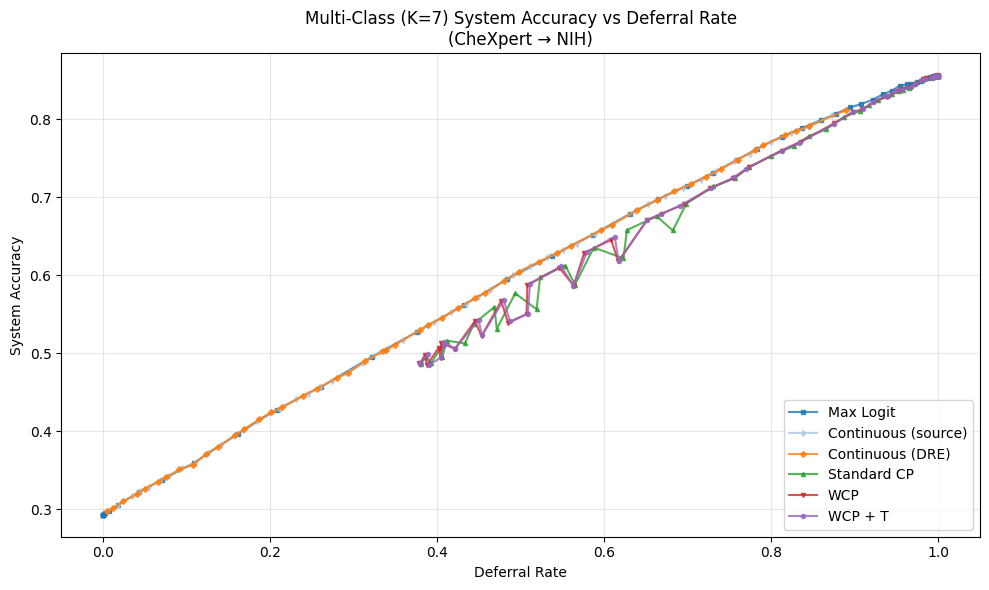

In [12]:
# Custom ARC plot with more methods
fig, ax = plt.subplots(figsize=(10, 6))

methods = {
    "Max Logit": (ml_results, "#1f77b4", "s"),
    "Continuous (source)": (cont_source_results, "#aec7e8", "d"),
    "Continuous (DRE)": (cont_dre_results, "#ff7f0e", "D"),
    "Standard CP": (std_cp_results, "#2ca02c", "^"),
    "WCP": (wcp_nots_results, "#d62728", "v"),
    "WCP + T": (wcp_results, "#9467bd", "o"),
}

for name, (res_list, color, marker) in methods.items():
    dr = np.array([r.deferral_rate for r in res_list])
    sa = np.array([r.system_accuracy for r in res_list])
    order = np.argsort(dr)
    ax.plot(
        dr[order],
        sa[order],
        label=name,
        color=color,
        marker=marker,
        markersize=3,
        linewidth=1.5,
        alpha=0.8,
    )

ax.set_xlabel("Deferral Rate")
ax.set_ylabel("System Accuracy")
ax.set_title(
    "Multi-Class (K=7) System Accuracy vs Deferral Rate\n(CheXpert \u2192 NIH)"
)
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

## 11. Coverage Verification

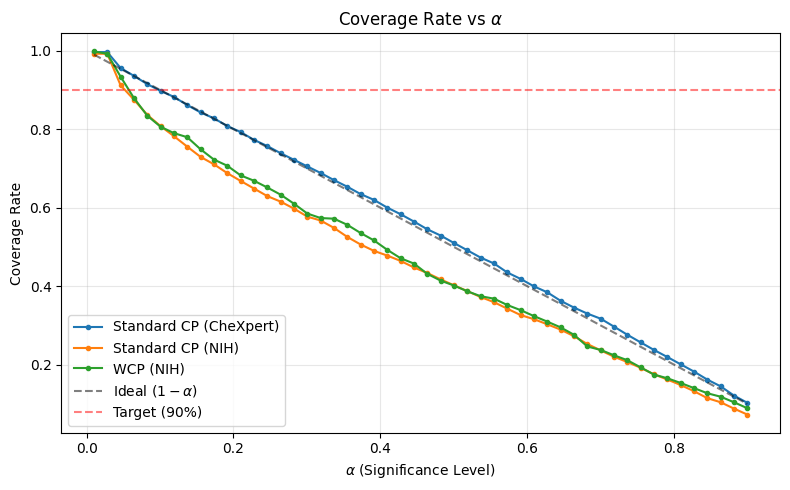

Coverage verification:
  alpha=0.1: CheXpert=0.8975, NIH(std)=0.8076, NIH(WCP)=0.8061 (target >= 0.9)
  alpha=0.3: CheXpert=0.7051, NIH(std)=0.5771, NIH(WCP)=0.5849 (target >= 0.7)
  alpha=0.5: CheXpert=0.5099, NIH(std)=0.4020, NIH(WCP)=0.4015 (target >= 0.5)


In [13]:
fig = plot_coverage_comparison(
    {
        "Standard CP (CheXpert)": std_cp_chex_results,
        "Standard CP (NIH)": std_cp_results,
        "WCP (NIH)": wcp_results,
    }
)
plt.show()

# Detailed coverage at selected alphas
print("Coverage verification:")
for a in [0.1, 0.3, 0.5]:
    r_chex = min(std_cp_chex_results, key=lambda r: abs(r.alpha_or_threshold - a))
    r_nih = min(std_cp_results, key=lambda r: abs(r.alpha_or_threshold - a))
    r_wcp = min(wcp_results, key=lambda r: abs(r.alpha_or_threshold - a))
    print(
        f"  alpha={a:.1f}: CheXpert={r_chex.coverage_rate:.4f}, "
        f"NIH(std)={r_nih.coverage_rate:.4f}, NIH(WCP)={r_wcp.coverage_rate:.4f} "
        f"(target >= {1 - a:.1f})"
    )

In [14]:
# Detailed coverage vs alpha table
check_alphas = [0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]

rows = []
for a in check_alphas:
    r_c = min(std_cp_chex_results, key=lambda r: abs(r.alpha_or_threshold - a))
    r_n = min(std_cp_results, key=lambda r: abs(r.alpha_or_threshold - a))
    r_w = min(wcp_results, key=lambda r: abs(r.alpha_or_threshold - a))
    rows.append(
        {
            "alpha": f"{a:.2f}",
            "1-alpha": f"{1 - a:.2f}",
            "CheXpert (std)": f"{r_c.coverage_rate:.4f}",
            "gap": f"{r_c.coverage_rate - (1 - a):+.4f}",
            "NIH (std)": f"{r_n.coverage_rate:.4f}",
            "gap ": f"{r_n.coverage_rate - (1 - a):+.4f}",
            "NIH (WCP)": f"{r_w.coverage_rate:.4f}",
            "gap  ": f"{r_w.coverage_rate - (1 - a):+.4f}",
        }
    )

df_cov = pd.DataFrame(rows)
print("Coverage vs alpha (gap = actual - target):")
print(df_cov.to_string(index=False))

print("\nKey observations:")
print("- In-domain (CheXpert): coverage tracks 1-alpha well (gap ~ 0)")
print("- NIH (std CP): coverage drops ~10pp below target due to distribution shift")
print("- NIH (WCP): barely different from std CP — unlike binary where WCP corrected")
print("  over-coverage from 99.6% to 93.1%")
print("\nContrast with binary (K=2) at alpha=0.1:")
print("  Binary std CP on NIH: 99.6% (over-coverage, target 90%)")
print("  Binary WCP on NIH:    93.1% (corrected towards target)")
print("  Multi-class std CP on NIH: 80.8% (under-coverage, target 90%)")
print("  Multi-class WCP on NIH:    80.6% (no correction)")

Coverage vs alpha (gap = actual - target):
alpha 1-alpha CheXpert (std)     gap NIH (std)    gap  NIH (WCP)   gap  
 0.05    0.95         0.9557 +0.0057    0.9117 -0.0383    0.9336 -0.0164
 0.10    0.90         0.8975 -0.0025    0.8076 -0.0924    0.8061 -0.0939
 0.15    0.85         0.8426 -0.0074    0.7292 -0.1208    0.7486 -0.1014
 0.20    0.80         0.8079 +0.0079    0.6879 -0.1121    0.7067 -0.0933
 0.30    0.70         0.7051 +0.0051    0.5771 -0.1229    0.5849 -0.1151
 0.40    0.60         0.6198 +0.0198    0.4898 -0.1102    0.5165 -0.0835
 0.50    0.50         0.5099 +0.0099    0.4020 -0.0980    0.4015 -0.0985
 0.60    0.40         0.4183 +0.0183    0.3262 -0.0738    0.3387 -0.0613
 0.70    0.30         0.3170 +0.0170    0.2363 -0.0637    0.2373 -0.0627
 0.80    0.20         0.2193 +0.0193    0.1620 -0.0380    0.1652 -0.0348
 0.90    0.10         0.1025 +0.0025    0.0727 -0.0273    0.0889 -0.0111

Key observations:
- In-domain (CheXpert): coverage tracks 1-alpha well (gap ~ 0)

## 12. Summary Table

In [15]:
# Summary at alpha=0.6 (operational regime for K=7)
alpha_summary = 0.6

print(f"\nResults Summary at alpha={alpha_summary} (K=7, NIH test)")
print("=" * 80)

all_methods = {
    "Max Logit": ml_results,
    "Continuous (source)": cont_source_results,
    "Continuous (DRE)": cont_dre_results,
    "Standard CP": std_cp_results,
    "WCP": wcp_nots_results,
    "WCP + T": wcp_results,
}

rows = []
# Get CP deferral rate at target alpha for matching
r_cp = min(std_cp_results, key=lambda r: abs(r.alpha_or_threshold - alpha_summary))
cp_defer = r_cp.deferral_rate

for name, res_list in all_methods.items():
    if name == "Max Logit":
        # Match deferral rate to CP
        r = min(res_list, key=lambda r: abs(r.deferral_rate - cp_defer))
    else:
        r = min(res_list, key=lambda r: abs(r.alpha_or_threshold - alpha_summary))
    rows.append(
        {
            "Method": name,
            "System Acc": f"{r.system_accuracy:.4f}",
            "Deferral": f"{r.deferral_rate:.4f}",
            "Coverage": f"{r.coverage_rate:.4f}"
            if not np.isnan(r.coverage_rate)
            else "N/A",
            "Avg Size": f"{r.average_set_size:.2f}"
            if not np.isnan(r.average_set_size)
            else "N/A",
            "Model Acc (kept)": f"{r.model_accuracy_on_kept:.4f}",
        }
    )

df = pd.DataFrame(rows)
print(df.to_string(index=False))


Results Summary at alpha=0.6 (K=7, NIH test)
             Method System Acc Deferral Coverage Avg Size Model Acc (kept)
          Max Logit     0.6252   0.5374      N/A      N/A           0.3559
Continuous (source)     0.6116   0.5112      N/A      N/A           0.3540
   Continuous (DRE)     0.6174   0.5217      N/A      N/A           0.3552
        Standard CP     0.6127   0.5536   0.3262     1.39           0.3103
                WCP     0.6289   0.5761   0.3372     1.44           0.3181
            WCP + T     0.6304   0.5797   0.3387     1.44           0.3172


## 13. Per-Class Analysis

In [16]:
# Per-class system accuracy using per-pathology expert sensitivity
expert_sens = np.array([DEFAULT_SENSITIVITY[p] for p in COMMON_PATHOLOGIES])

# Use WCP+T at alpha=0.6
alpha_analysis = 0.6
wcp_final = WeightedConformalPredictor(penalty=0.0, kreg=1, randomized=False)
wcp_final.calibrate(cal_logits_ts, chex_cal_l, cal_weights)
pred_sets = wcp_final.predict(te_nih_logits_ts, te_nih_weights, alpha=alpha_analysis)
preds, defer_mask = _predictions_from_sets(pred_sets, te_nih_logits_ts)

print(f"Per-class system accuracy at alpha={alpha_analysis} (WCP + T)")
print("=" * 75)

rng_expert = np.random.RandomState(SEED)
rows = []
for k in range(K):
    class_mask = nih_te_l == k
    n_k = class_mask.sum()
    if n_k == 0:
        continue
    kept_k = class_mask & ~defer_mask
    deferred_k = class_mask & defer_mask
    model_correct_k = (
        int((preds[kept_k] == nih_te_l[kept_k]).sum()) if kept_k.sum() > 0 else 0
    )
    expert_correct_k = int(rng_expert.binomial(int(deferred_k.sum()), expert_sens[k]))
    sys_acc_k = (model_correct_k + expert_correct_k) / n_k
    rows.append(
        {
            "Pathology": COMMON_PATHOLOGIES[k],
            "N": n_k,
            "Deferred": int(deferred_k.sum()),
            "Defer%": f"{deferred_k.sum() / n_k:.1%}",
            "Expert Sens": f"{expert_sens[k]:.2f}",
            "Model Acc (kept)": f"{model_correct_k / kept_k.sum():.4f}"
            if kept_k.sum() > 0
            else "N/A",
            "System Acc": f"{sys_acc_k:.4f}",
            "Low-N": "*" if n_k < 50 else "",
        }
    )

df_per_class = pd.DataFrame(rows)
print(df_per_class.to_string(index=False))
print("\n* = Low sample count, interpret with caution")

Per-class system accuracy at alpha=0.6 (WCP + T)
    Pathology   N  Deferred Defer% Expert Sens Model Acc (kept) System Acc Low-N
  Atelectasis 625       364  58.2%        0.75           0.3678     0.5968      
 Cardiomegaly 378       205  54.2%        0.90           0.4046     0.6667      
Consolidation 208       115  55.3%        0.70           0.0108     0.3798      
        Edema  24        12  50.0%        0.80           0.3333     0.5000     *
     Effusion 465       268  57.6%        0.85           0.4162     0.6839      
    Pneumonia  87        42  48.3%        0.65           0.0889     0.3218      
 Pneumothorax 126        74  58.7%        0.85           0.0192     0.5238      

* = Low sample count, interpret with caution


## 14. Binary vs Multi-Class Comparison

Compare prediction set size distributions to verify that the binary CP
bottleneck is resolved at K=7.

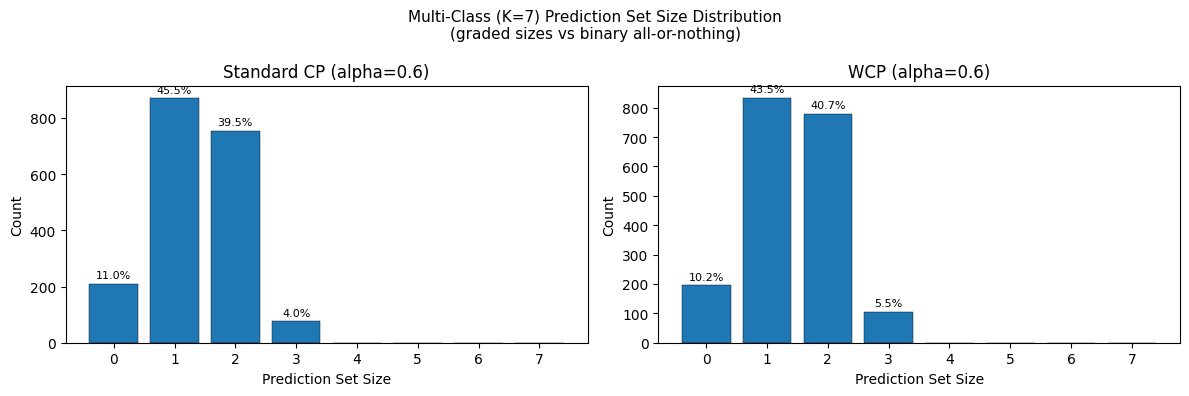

Standard CP: avg_size=1.37, singleton=871/1913 (45.5%), defer=54.5%
WCP:         avg_size=1.42, singleton=833/1913 (43.5%), defer=56.5%


In [17]:
# Prediction set size distribution at alpha=0.6
alpha_compare = 0.6

# Standard CP
cp = ConformalPredictor(penalty=0.0, kreg=1, randomized=False)
cp.calibrate(cal_logits_ts, chex_cal_l, alpha=alpha_compare)
ps_std = cp.predict(te_nih_logits_ts)
ss_std = ps_std.sum(axis=1)

# WCP
wcp = WeightedConformalPredictor(penalty=0.0, kreg=1, randomized=False)
wcp.calibrate(cal_logits_ts, chex_cal_l, cal_weights)
ps_wcp = wcp.predict(te_nih_logits_ts, te_nih_weights, alpha=alpha_compare)
ss_wcp = ps_wcp.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, ss, title in [
    (axes[0], ss_std, f"Standard CP (alpha={alpha_compare})"),
    (axes[1], ss_wcp, f"WCP (alpha={alpha_compare})"),
]:
    counts = np.bincount(ss.astype(int), minlength=K + 1)
    ax.bar(range(K + 1), counts, edgecolor="black", linewidth=0.3)
    ax.set_xlabel("Prediction Set Size")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.set_xticks(range(K + 1))
    # Annotate with percentages
    for i, c in enumerate(counts):
        if c > 0:
            ax.text(
                i,
                c + len(nih_te_l) * 0.01,
                f"{c / len(nih_te_l) * 100:.1f}%",
                ha="center",
                fontsize=8,
            )

fig.suptitle(
    "Multi-Class (K=7) Prediction Set Size Distribution\n"
    "(graded sizes vs binary all-or-nothing)",
    fontsize=11,
)
plt.tight_layout()
plt.show()

# Summary stats
print(
    f"Standard CP: avg_size={ss_std.mean():.2f}, singleton={int((ss_std == 1).sum())}/{len(ss_std)} "
    f"({(ss_std == 1).mean() * 100:.1f}%), defer={(ss_std != 1).mean() * 100:.1f}%"
)
print(
    f"WCP:         avg_size={ss_wcp.mean():.2f}, singleton={int((ss_wcp == 1).sum())}/{len(ss_wcp)} "
    f"({(ss_wcp == 1).mean() * 100:.1f}%), defer={(ss_wcp != 1).mean() * 100:.1f}%"
)

## 15. Deferral Rate vs Target Coverage

Plot the relationship between target coverage (1 - alpha) and deferral rate for the conformal-based methods.

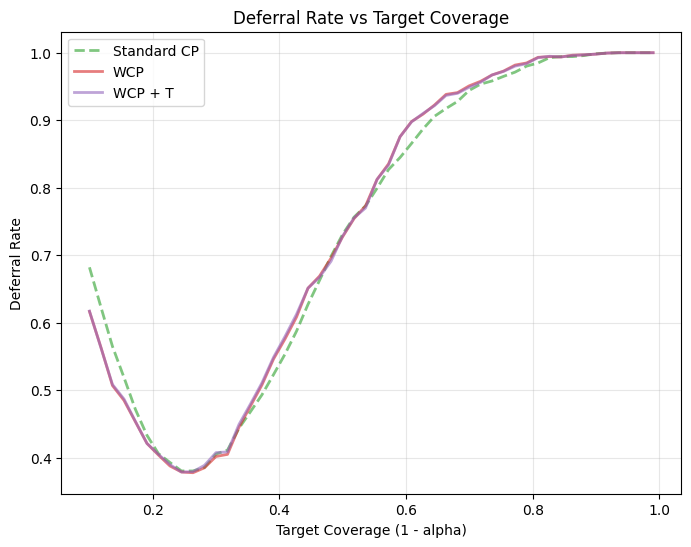

In [ ]:
# Plot Deferral Rate vs Target Coverage (1 - alpha)
fig, ax = plt.subplots(figsize=(8, 6))

methods_alpha = {
    "Standard CP": (std_cp_results, "#2ca02c", "--"),
    "WCP": (wcp_nots_results, "#d62728", "-"),
    "WCP + T": (wcp_results, "#9467bd", "-"),
}

for name, (res_list, color, style) in methods_alpha.items():
    # Filter out results where alpha isn't defined or relevant
    # For these methods, alpha_or_threshold corresponds to alpha
    alphas = np.array([r.alpha_or_threshold for r in res_list])
    dr = np.array([r.deferral_rate for r in res_list])

    target_coverage = 1 - alphas

    # Sort for clean plotting
    order = np.argsort(target_coverage)

    ax.plot(
        target_coverage[order],
        dr[order],
        label=name,
        color=color,
        linestyle=style,
        linewidth=2,
        alpha=0.6,
    )

ax.set_xlabel("Target Coverage (1 - alpha)")
ax.set_ylabel("Deferral Rate")
ax.set_title("Deferral Rate vs Target Coverage")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()